In [1]:
try:
    import base64
    import io
    import json

    import google.colab  # noqa: F401
    import torch

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia

    # Code below is to download the pretrained model weights stored on github
    !mkdir models
    !curl -o gitlfsbinary https://api.github.com/repos/aria-ml/dataeval/git/blobs/ad520d5589fdc49830f98d28aa5eaed0bbdfe5cb

    with open("gitlfsbinary") as f:
        rawfile = json.load(f)

    binaryfile = base64.b64decode(rawfile["content"])
    buffer = io.BytesIO(binaryfile)

    temp = torch.load(buffer, weights_only=False)
    torch.save(temp, "models/ae")

    del rawfile
    del binaryfile
    del buffer
    del temp
except Exception:
    pass

%pip install -q tabulate

/dataeval/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import math

import matplotlib.pyplot as plt  # type: ignore
import numpy as np
import torch
import torch.nn as nn
from sklearn.manifold import TSNE  # type: ignore

from dataeval.metrics.bias import coverage
from dataeval.utils.torch.datasets import MNIST

In [3]:
# We train a 10-d autoencoder on MNIST data for 1000 epochs with batch size 128
num_epochs = 1000
batch_size = 128

# Set seeds
torch.manual_seed(14)

# MNIST with mean 0 unit variance
trainset = MNIST(
    root="./data",
    train=True,
    download=True,
    size=2000,
    unit_interval=True,
    dtype=np.float32,
    channels="channels_first",
    normalize=(0.1307, 0.3081),
)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


In [4]:
# Define model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        return x

In [5]:
sd = torch.load("models/ae")
model = Autoencoder()
model.load_state_dict(sd)

/tmp/ipykernel_224/3718087727.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load("models/ae")


<All keys matched successfully>

In [6]:
# Get images to predict on and predict
pred = trainset.data
label = trainset.targets
mod_preds = model.encode(torch.tensor(pred)).detach().numpy()

In [7]:
# Visualize 10d as 2d with TSNE
tsne = TSNE(n_components=2)
red_dim = tsne.fit_transform(mod_preds)

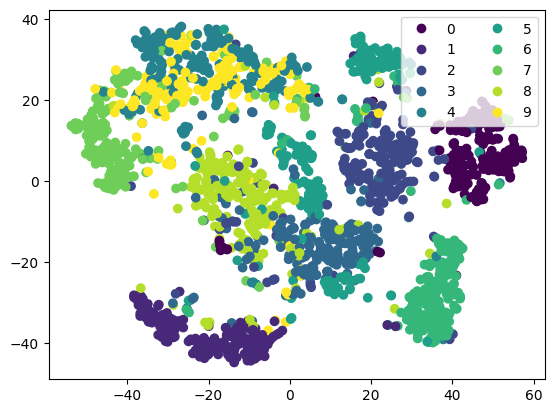

In [8]:
# Plot results with color being label
fig, ax = plt.subplots()
scatter = ax.scatter(
    x=red_dim[:, 0],
    y=red_dim[:, 1],
    c=label,
    label=label,
)
ax.legend(*scatter.legend_elements(), loc="upper right", ncols=2)
plt.show()

In [9]:
# Way to calculate data-agnostic radius (probably don't want to do this)
k = 20
n = 2000
d = 10
rho = (1 / math.sqrt(math.pi)) * ((4 * 20 * math.gamma(d / 2 + 1)) / (n)) ** (1 / d)

# Way to calculate data-adaptive radius (most extreme 1% are uncovered)
percent = 0.01
cutoff = int(n * percent)

In [10]:
# Use data adaptive cutoff
cvrg = coverage(mod_preds, radius_type="adaptive")

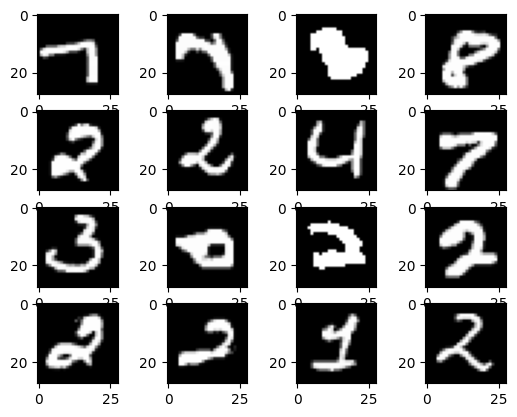

In [11]:
# Plot the least covered 0.5%
f, axs = plt.subplots(4, 4)
axs = axs.flatten()
for count, i in enumerate(axs):
    i.imshow(np.squeeze(pred[cvrg.indices[count]]), cmap="gray")

In [12]:
### TEST ASSERTION CELL ###
wonky = sum(label[i] == 7 or label[i] == 2 for idx, i in enumerate(cvrg.indices) if idx < 16)
assert (wonky / 16) > 0.5